# Tuning XGBoost for Seqencue to Sequence Prediction: Random Splitting

## Dataset

In [1]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv')

In [2]:
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [3]:
print('size of dataset:', len(df))

size of dataset: 144


# Plot the Series to see Trend and Seasonality

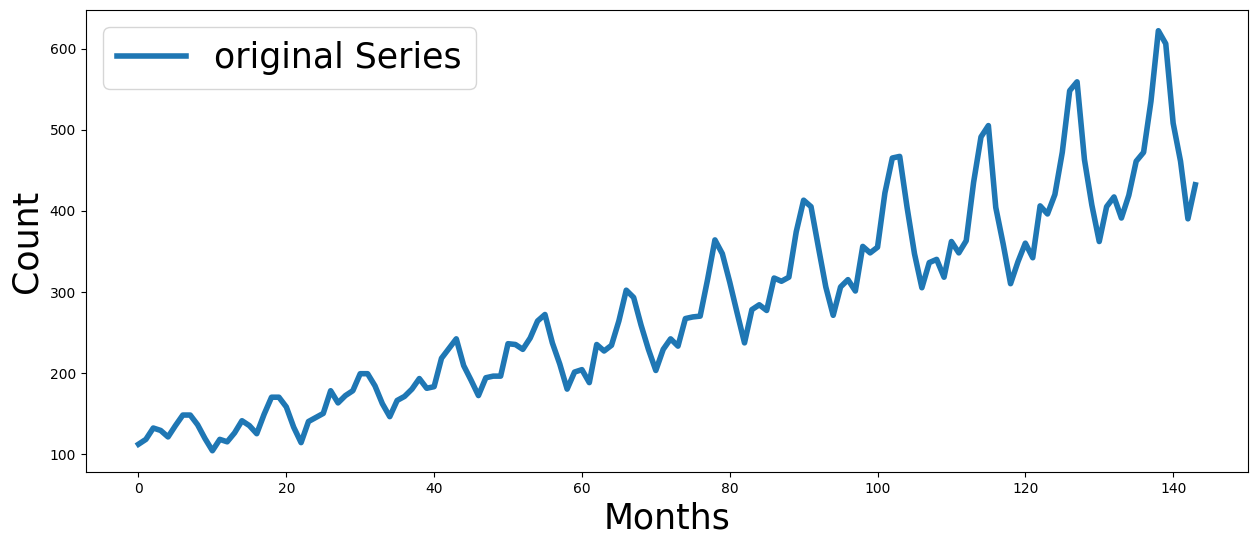

In [4]:
from matplotlib import pyplot as plt
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(6)
plt.plot(df['#Passengers'], linewidth = 4, label = "original Series")
plt.legend(fontsize=25)
plt.xlabel('Months', fontsize = 25)
plt.ylabel('Count', fontsize = 25)
plt.show()

# Convert it into a Sequence to Sequence Prediction Problem
- Using 12 months data to predict for the next 6 months

In [5]:
def Tranform_dataset(input_length, output_length, data):
    
    df = data.copy()
    
    #input columns creation
    i = 1
    while i < input_length:
        df[f'x_{i}'] = df['#Passengers'].shift(-i)
        i = i + 1
    
    #output columns creations
    j = 0
    while j < output_length:
        df[f'y_{j}'] = df['#Passengers'].shift(-output_length-j)
        j = j + 1
    
    #drop some of the last columns
    df = df.dropna(axis=0)
    
    return df

In [6]:
full_data = Tranform_dataset(12, 6, df)
print(len(full_data))

133


In [7]:
full_data.head()

,Month,#Passengers,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,x_11,y_0,y_1,y_2,y_3,y_4,y_5
0,1949-01,112,118.0,132.0,129.0,121.0,135.0,148.0,148.0,136.0,119.0,104.0,118.0,148.0,148.0,136.0,119.0,104.0,118.0
1,1949-02,118,132.0,129.0,121.0,135.0,148.0,148.0,136.0,119.0,104.0,118.0,115.0,148.0,136.0,119.0,104.0,118.0,115.0
2,1949-03,132,129.0,121.0,135.0,148.0,148.0,136.0,119.0,104.0,118.0,115.0,126.0,136.0,119.0,104.0,118.0,115.0,126.0
3,1949-04,129,121.0,135.0,148.0,148.0,136.0,119.0,104.0,118.0,115.0,126.0,141.0,119.0,104.0,118.0,115.0,126.0,141.0
4,1949-05,121,135.0,148.0,148.0,136.0,119.0,104.0,118.0,115.0,126.0,141.0,135.0,104.0,118.0,115.0,126.0,141.0,135.0


# X, Y: Full dataset

In [8]:
X_cols = [col for col in full_data.columns if col.startswith('x')]
X_cols.insert(0, '#Passengers')

y_cols = [col for col in full_data.columns if col.startswith('y')]
X = full_data[X_cols].values
y = full_data[y_cols].values

print(X.shape, y.shape)

(133, 12) (133, 6)


# Train Test Random Split (Shuffle=True)

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

print(X_train.shape, X_test.shape)

(93, 12) (40, 12)


# Using Mango to tune the parameters

In [27]:
from mango.tuner import Tuner

from scipy.stats import uniform

param_dict = {"learning_rate": uniform(0.01, 0.5),
              "max_depth": range(5,10),
              "n_estimators": range(5,50),
              "subsample": uniform(0.7, 0.3),
             "objective":['reg:squarederror']}

In [28]:
#!pip install xgboost

In [29]:
import xgboost as xgb
import numpy as np

def mape(y_true, y_pred):
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)

def objective_Xgboost(args_list):
    global X_train, y_train, X_test, y_test, model, count_called
    
    results = []
    for hyper_par in args_list:
        clf = xgb.XGBRegressor(**hyper_par, random_state = 1)
        clf.fit(X_train, y_train.ravel())
        
        y_pred = clf.predict(X_test) 
        error = mape(y_test, y_pred)
        results.append(error)
        
    return results

In [30]:
conf_Dict = dict()
conf_Dict['initial_random']= 10
conf_Dict['batch_size'] = 1
conf_Dict['num_iteration'] = 100
conf_Dict['domain_size'] = 10000

In [31]:
tuner_user = Tuner(param_dict, objective_Xgboost,conf_Dict)

In [32]:
results = tuner_user.minimize()

  0%|          | 0/100 [00:00<?, ?it/s]

In [33]:
print('best hyper parameters:',results['best_params'])
print('best objective:',results['best_objective'])

best hyper parameters: {'learning_rate': 0.16804672778939195, 'max_depth': 9, 'n_estimators': 49, 'objective': 'reg:squarederror', 'subsample': 0.9329233664407354}
best objective: 2.0


# Train the best model

In [34]:
model = xgb.XGBRegressor(**results['best_params'], random_state = 1)
model.fit(X_train, y_train.ravel())
y_pred = model.predict(X_test) 

# See individual sample test predictions

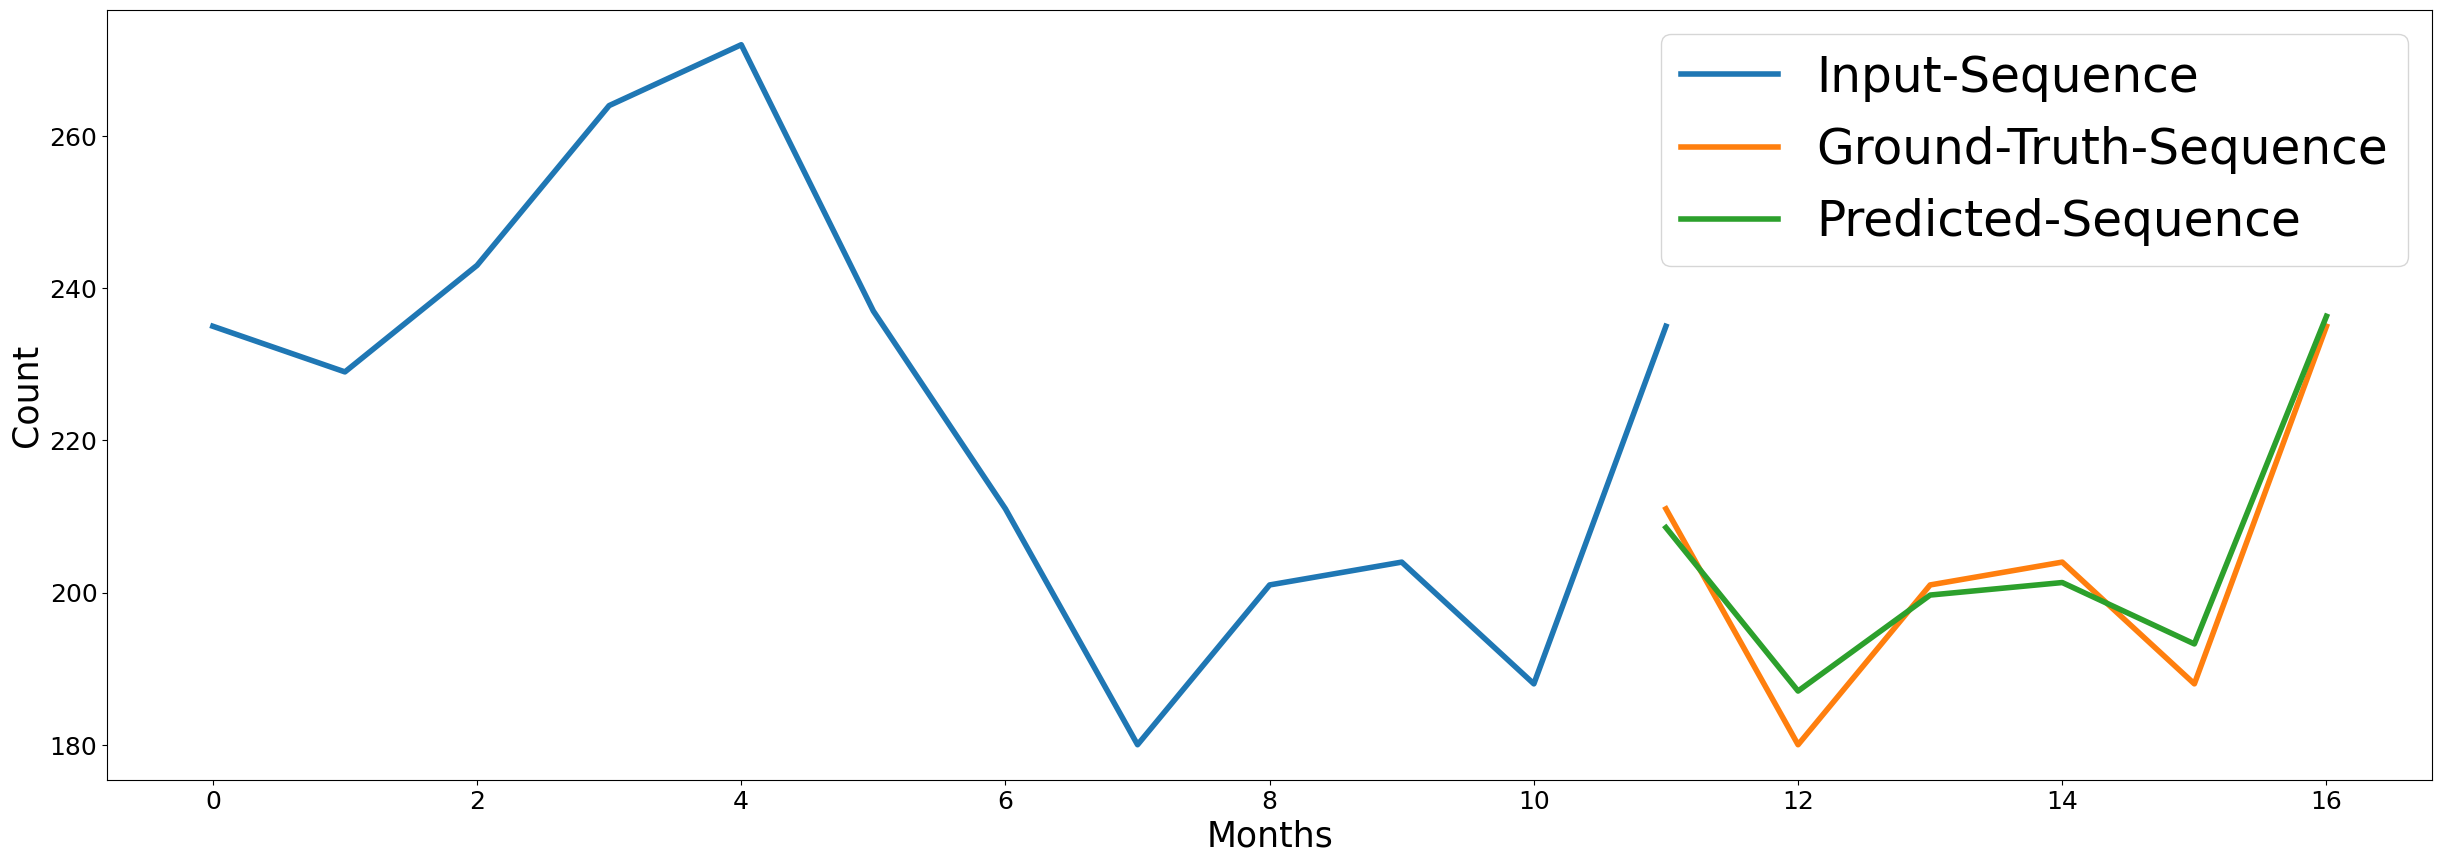

In [35]:
from matplotlib import pyplot as plt
import numpy as np 

fig = plt.figure(figsize=(30,10))
plt.rcParams.update({'font.size': 18})

plt.plot(np.arange(0, 12, 1), X_test[0],label='Input-Sequence', lw=4)
plt.plot(np.arange(11, 11+6, 1), y_test[0],label='Ground-Truth-Sequence', lw=4)
plt.plot(np.arange(11, 11+6, 1), y_pred[0],label='Predicted-Sequence', lw=4)

plt.xlabel('Months', fontsize = 25)
plt.ylabel('Count', fontsize = 25)
    
plt.legend(fontsize = 35)
plt.show()

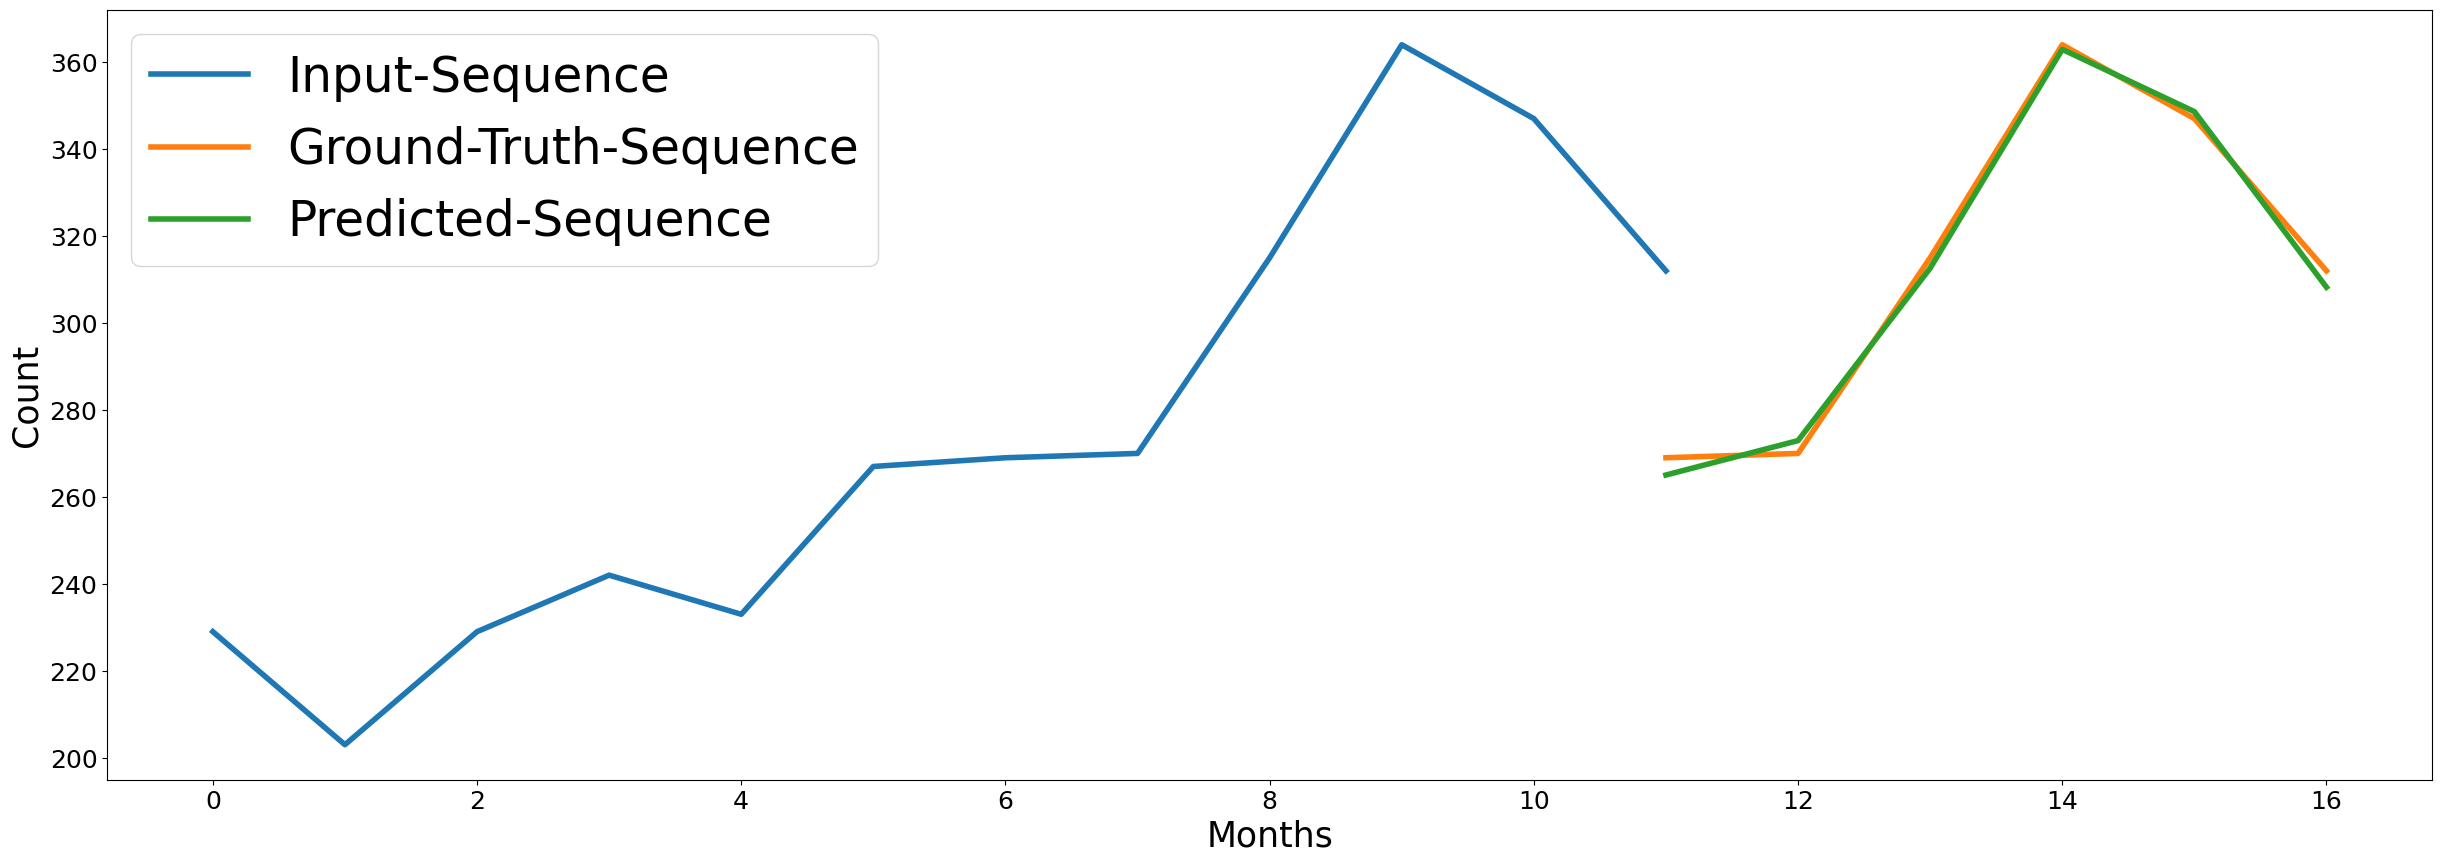

In [36]:
from matplotlib import pyplot as plt
import numpy as np 

fig = plt.figure(figsize=(30,10))
plt.rcParams.update({'font.size': 18})

plt.plot(np.arange(0, 12, 1), X_test[1],label='Input-Sequence', lw=4)
plt.plot(np.arange(11, 11+6, 1), y_test[1],label='Ground-Truth-Sequence', lw=4)
plt.plot(np.arange(11, 11+6, 1), y_pred[1],label='Predicted-Sequence', lw=4)

plt.xlabel('Months', fontsize = 25)
plt.ylabel('Count', fontsize = 25)
    
plt.legend(fontsize = 35)
plt.show()

# Combine predictions on all the data: Note some of the last samples are left in this simple combination approach

In [37]:
pred = []
truth = []

y_pred = model.predict(X) 

for i in range(len(y_pred)):
    pred.append(y_pred[i][0])
    truth.append(y[i][0])

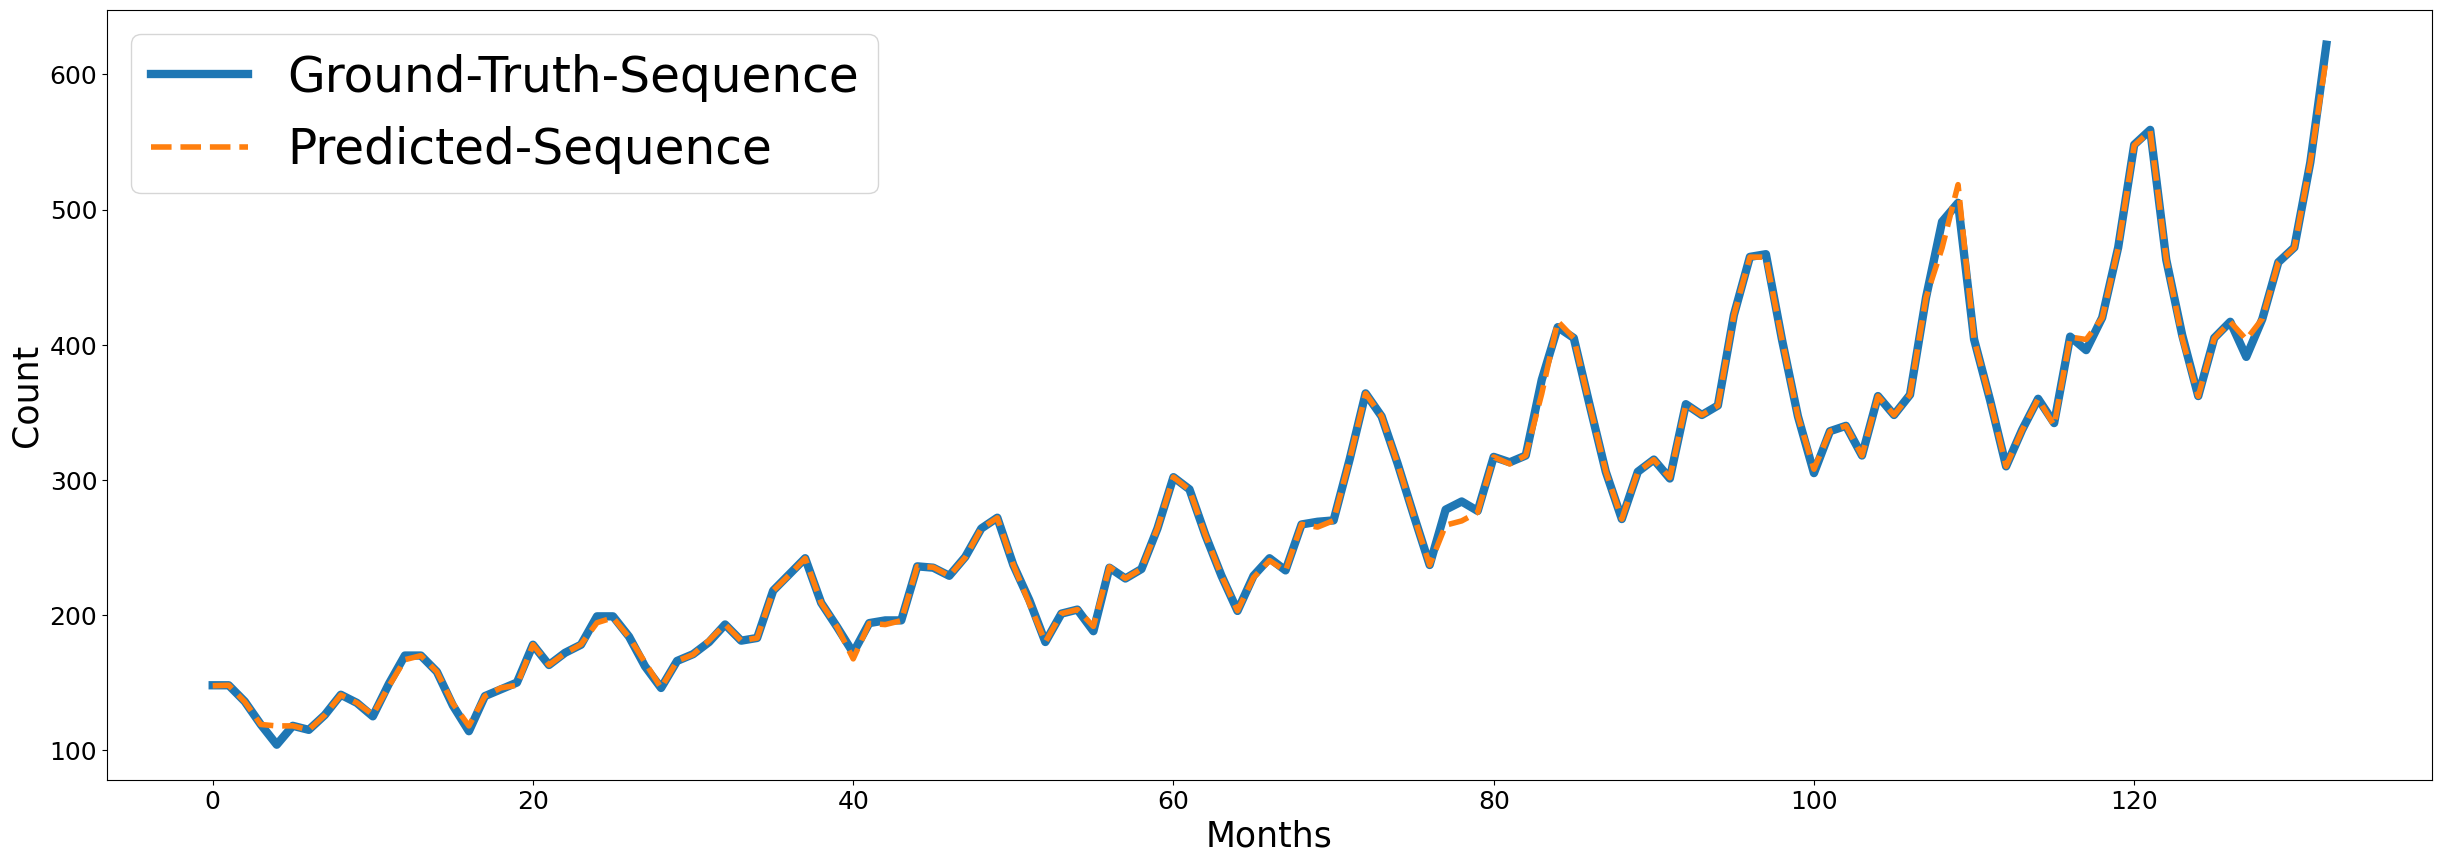

In [38]:
from matplotlib import pyplot as plt
import numpy as np 

fig = plt.figure(figsize=(30,10))
plt.rcParams.update({'font.size': 18})

plt.plot(truth,label='Ground-Truth-Sequence', lw=6)
plt.plot(pred,label='Predicted-Sequence', lw=4, linestyle='dashed')

plt.xlabel('Months', fontsize = 25)
plt.ylabel('Count', fontsize = 25)
    
plt.legend(fontsize = 35)
plt.show()